In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import tensorflow as tf
from matplotlib import pyplot as plt

cust = pd.read_csv("cust_journey_metrics15-19.csv")
cust["month"] = pd.to_datetime(cust["month"], format='%Y-%m').dt.to_period('m')
wait = pd.read_csv("wait_assessment15-19.csv")
wait["month"] = pd.to_datetime(wait["month"], format='%Y-%m').dt.to_period('m')
incidents = pd.read_csv("Major_Incidents.csv")
incidents["month"] = pd.to_datetime(incidents["month"], format='%Y-%m').dt.to_period('m')
failures = pd.read_csv("Mean_Distance_Between_Failures_.csv")
failures["month"] = pd.to_datetime(failures["month"], format='%Y-%m').dt.to_period('m')
failures.sort_values(by='month', inplace=True)
conditions = [(failures['car class'].isin(['R142', 'R142A', 'R62', 'R62A', 'R188-NEW', 'R188-CONVERSION', 'ADIVISION'])),
                (failures['car class'].isin(['R68A', 'R68', 'R143', 'R46', 'R160', 'R179', 'R32', 'BDIVISION']))]
divisions = ['A DIVISION', 'B DIVISION']
failures['division'] = np.select(condlist=conditions, choicelist=divisions)
failures.drop(failures[failures['month'] > '2019-12'].index, inplace=True)
servdelivered = pd.read_csv("Service_Delivered__2015-2019.csv")
servdelivered["month"] = pd.to_datetime(servdelivered["month"], format='%Y-%m').dt.to_period('m')
timeperf = pd.read_csv("MTA_Subway_Terminal_On-Time_Performance__2015-2019.csv")
timeperf["month"] = pd.to_datetime(timeperf["month"], format='%Y-%m').dt.to_period('m')
class_assignments = pd.read_csv('class_assignments.csv')
class_assignments['month'] = pd.to_datetime(class_assignments["month"], format='%Y-%m').dt.to_period('m')
class_assignments.drop(class_assignments[class_assignments['line'] == 'T'].index, inplace=True)


In [2]:
# failures = failures.merge(right=class_assignments, on=['month', 'division', 'car class'], how='left')
# failures.to_csv('failures.csv')
# class_assignments.merge(right=failures, on=['month'], how=)
# class_assignments
# data.columns

In [3]:
# data = pd.concat(objs=[cust, wait, incidents, servdelivered, timeperf], axis=1, join='inner')
data = cust.merge(right=wait, how="inner", on=['month', 'division','line','period'])
data = data.merge(right=incidents, how='inner', on=['month', 'division','line', 'day_type'])
data = data.rename(columns={'category':'incident_cat', 'count': 'incident_count'})
# data = data.merge(right=failures, how='inner', on=['month', 'division'])
data = data.merge(right=servdelivered, how='inner', on=['month', 'division', 'line', 'day_type'])
data = data.merge(right=timeperf, on=['month', 'line', 'division', 'day_type'])
data.drop(data[data['month']=='2018-08'].index, inplace=True)
data.drop(data[data['division']=='Systemwide'].index, inplace=True)
data['year'] = data['month'].dt.year
data['month'] = data['month'].dt.month

# data = data.drop(columns="division")
# month = data["month"]
data.to_csv("data.csv")
data.columns
data.shape

x = data[['year','month', 'division', 'line', 'period', 'num_passengers', 'day_type', 'incident_cat', 'incident_count', 'num_sched_trains', 'num_actual_trains', 'num_sched_trips']]

y = data[['additional platform time', 'additional train time', 'over_five_mins_perc', 'num_on_time_trips']]

scaler = MinMaxScaler()

cat_feats = ['division', 'period', 'line', 'incident_cat']
for var in cat_feats:
    dummies = pd.get_dummies(x[var], prefix=var)
    x = pd.concat([x, dummies], axis=1)
    x.drop([var], axis=1, inplace=True)
x_cols = x.columns


x = pd.DataFrame(scaler.fit_transform(x), columns= x_cols, dtype='float32')
y = pd.DataFrame(scaler.fit_transform(y), columns=y.columns, dtype='float32')

X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7, test_size = 0.3, shuffle=True, stratify=None)
X_train = X_train.astype('float32')
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=0.5, test_size = 0.5, shuffle=True, stratify=None)

# test_x = test[['month', 'division', 'line', 'period', 'num_passengers', 'day_type', 'incident_cat', 'incident_count', 'num_sched_trains', 'num_actual_trains', 'num_sched_trips']]
# test_y = test[['additional platform time', 'additional train time', 'over_five_mins_perc', 'num_on_time_trips']]
# data['line'].unique()
# X_pred = data['month', 'division', 'line', 'period', 'num_passengers', 'day_type', 'incident_cat', 'incident_count', 'num_sched_trains', 'num_actual_trains', 'num_sched_trips']
# X_pred = X_pred.iloc[:0]
# y_pred = data['additional platformtime', 'additional train time', 'over_five_mins_perc', 'num_on_time_trips']
x.shape

(3720, 42)

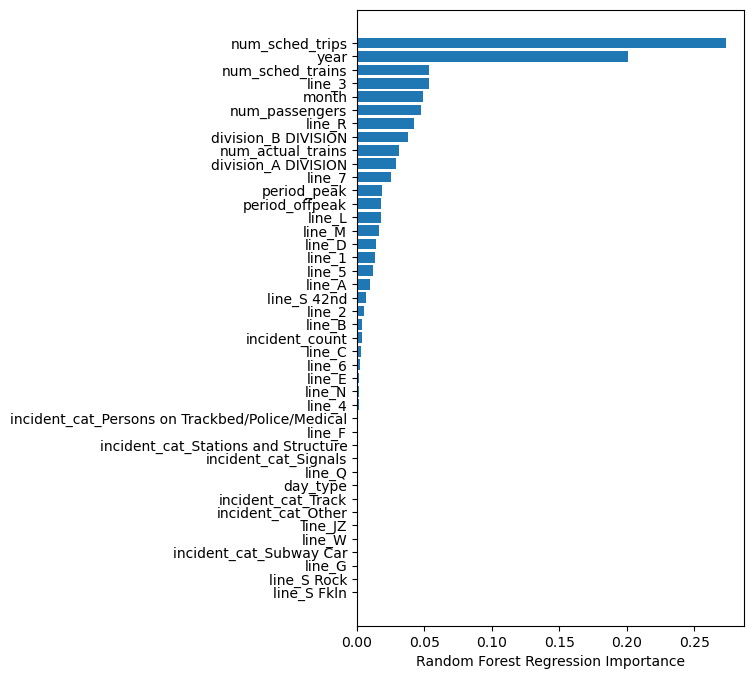

In [4]:
forest = RandomForestRegressor(n_estimators=100)
forest.fit(X_train, y_train)
sorted_idx = forest.feature_importances_.argsort()

plt.figure(figsize=(5,8))
plt.xlabel("Random Forest Regression Importance")
plt.barh(forest.feature_names_in_[sorted_idx], forest.feature_importances_[sorted_idx])
plt.savefig("feat_importance_transformed")


Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 p_re_lu (PReLU)             (None, 42)                42        
                                                                 
 batch_normalization (BatchN  (None, 42)               168       
 ormalization)                                                   
                                                                 
 p_re_lu_1 (PReLU)           (None, 42)                42        
                                                                 
 batch_normalization_1 (Batc  (None, 42)               168       
 hNormalization)                                                 
                                                                 
 p_re_lu_2 (PReLU)           (None, 42)                42        
                                        

2023-04-25 13:43:48.666130: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-25 13:43:48.666271: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/1000


2023-04-25 13:43:48.881738: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-25 13:43:49.115281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 1s 29ms/step - loss: 1.5144 - accuracy: 0.2481 - val_loss: 0.4776 - val_accuracy: 0.4462
Epoch 2/1000
 1/27 [>.............................] - ETA: 0s - loss: 1.4376 - accuracy: 0.2700

2023-04-25 13:43:50.089032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 0s 15ms/step - loss: 1.4487 - accuracy: 0.2435 - val_loss: 0.4251 - val_accuracy: 0.3853
Epoch 3/1000
27/27 [==============================] - 0s 14ms/step - loss: 1.4022 - accuracy: 0.2423 - val_loss: 0.4013 - val_accuracy: 0.3441
Epoch 4/1000
27/27 [==============================] - 0s 14ms/step - loss: 1.3650 - accuracy: 0.2446 - val_loss: 0.4002 - val_accuracy: 0.3244
Epoch 5/1000
27/27 [==============================] - 0s 15ms/step - loss: 1.3121 - accuracy: 0.2462 - val_loss: 0.4123 - val_accuracy: 0.3029
Epoch 6/1000
27/27 [==============================] - 0s 14ms/step - loss: 1.2710 - accuracy: 0.2465 - val_loss: 0.4351 - val_accuracy: 0.2724
Epoch 7/1000
27/27 [==============================] - 0s 16ms/step - loss: 1.2350 - accuracy: 0.2458 - val_loss: 0.4667 - val_accuracy: 0.2599
Epoch 8/1000
27/27 [==============================] - 0s 14ms/step - loss: 1.2001 - accuracy: 0.2462 - val_loss: 0.5042 - val_accuracy: 0.2491
Epoch 9/1000

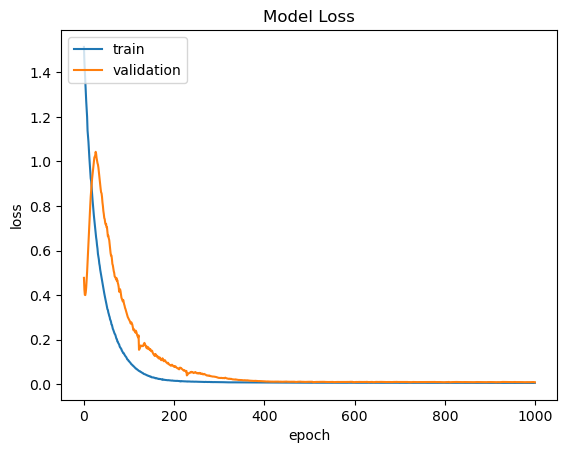

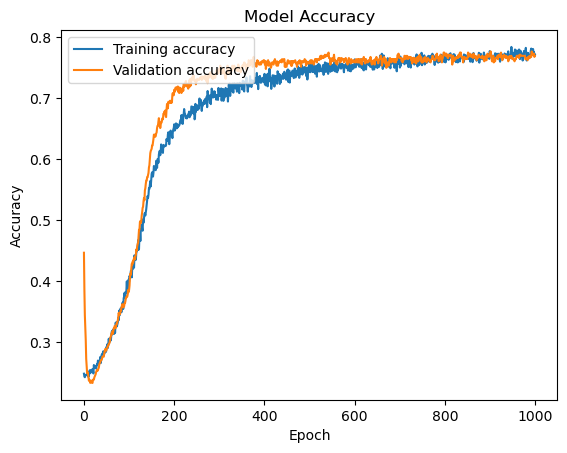

In [5]:
NUM_FEATS = len(X_train.columns)
BATCH_SIZE = 100
LR = 0.0001
NUM_LAYERS = 3
EPOCHS = 1000

def residualBlock(x):
    res = x
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Add()([x, res])
    return x

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape = NUM_FEATS, dtype='float32'))
# model.add(tf.keras.layers.PReLU(alpha_initializer='zeros'))
model.add(tf.keras.layers.PReLU(alpha_initializer=tf.keras.initializers.Constant(value=0.25)))
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.PReLU(alpha_initializer='zeros'))
model.add(tf.keras.layers.PReLU(alpha_initializer=tf.keras.initializers.Constant(value=0.25)))
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.PReLU(alpha_initializer='zeros'))
model.add(tf.keras.layers.PReLU(alpha_initializer=tf.keras.initializers.Constant(value=0.25)))
model.add(tf.keras.layers.Dense(4))

model.summary()

tf.config.set_soft_device_placement(True)

with tf.device('/gpu:0'):
    model.compile(loss = 'mean_squared_error', optimizer = tf.keras.optimizers.Adam(learning_rate=LR), metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Visualize model history
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()